# Stock Price Indicator
## I. ETL Pipeline Preparation
### 1. Import libraries and load datasets.
- Import Python libraries
- Load data from Yahoo Finance (Accessing data from the Yahoo finance plattform via the corresponing API you are able to download data since 1950 (if the stock existed))

In [714]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from alpha_vantage.timeseries import TimeSeries
import os.path


In [716]:
# Download data from Alpha-Vantage

def download_stock_data(symbol, API_key='AG0F6BKQTUPYSY99'):
    try:
        ts = TimeSeries(key = API_key, output_format = 'pandas')
        data = ts.get_daily_adjusted(symbol, outputsize='full') 
        symbol = symbol.upper()
        df = data[0]['5. adjusted close'].reset_index().rename(columns={"5. adjusted close": symbol}).sort_values('date', ascending =True)
        df.to_csv('app/data_wrangling/'+symbol+'.csv', index = False)
        return df
    except Exception as e:
                print('Execption occurred: {}'.format(e))

In [718]:
download_stock_data('AAPL')

,date,AAPL
5428,1999-11-01,0.595872
5427,1999-11-02,0.616062
5426,1999-11-03,0.625658
5425,1999-11-04,0.641933
5424,1999-11-05,0.677937
...,...,...
4,2021-05-24,127.100000
3,2021-05-25,126.900000
2,2021-05-26,126.850000
1,2021-05-27,125.280000


In [633]:
# Import data from csv file

def get_data(symbol='AAPL', start_date='2020-01-01', end_date='2020-12-31'):
    '''
    Setup an empty dataframe with the given timeperiod as index to be used as instance for further gathered data.
    Then loads data from a .csv file for the selected symbol and selects the Adj Close column
    INPUT: 
    symbols - list - symbols of listed stocks
    start_date - datetime - Beginning of the period to analyze
    end_date - datetime - End of the period to analyze
    
    OUTPUT
    df - dataframe - Dataframe containing the Adj Close for the symbol with the time period as index (ordered ascending)
    '''
    try:
        dates= pd.date_range(start_date, end_date)
        df = pd.DataFrame(index=dates)
    
        if os.path.isfile('app/data_wrangling/'+symbol+'.csv') == False:
            print("No such file exists; will be downloaded")
            download_stock_data(symbol)

        df_tmp = pd.read_csv('app/data_wrangling/'+symbol+'.csv', index_col = 'date')
        
        df = df.join(df_tmp)
        df = df.dropna()
    
        return df
    except Exception as e:
                print('Execption occurred: {}'.format(e))

In [874]:
data_analysis_df = get_data(symbol='AAPL', start_date='2020-12-25', end_date='2021-05-25')
data_analysis_df.head()

,AAPL
2020-12-28,136.255198
2020-12-29,134.440987
2020-12-30,133.294645
2020-12-31,132.267922
2021-01-04,128.998355


### 2. Normalize data and plot to check for anomalies

In [875]:
# Noramlize the stock price data

def normalize_stock_data(df):
    df = df/df.iloc[0,:]
    return df

In [876]:
data_analysis_norm = normalize_stock_data(data_analysis_df)

In [877]:
# Plot stock price data and check for anomalies

def plot_stock_data(df):
    if isinstance(df, pd.Series):
        plt.figure(figsize=(12,8))
        ax1 = df.plot()
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('Stock price development')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.figure(figsize=(12,18))
        ax2 = plt.subplot(2,1,1)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('Stock price development')
        for col in df.columns:
            df[col].plot()
    
        plt.legend(loc='upper right')

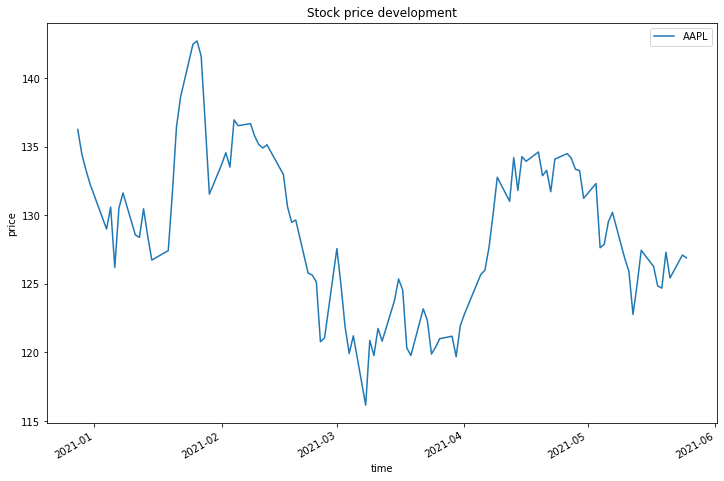

In [878]:
plot_stock_data(data_analysis_df)

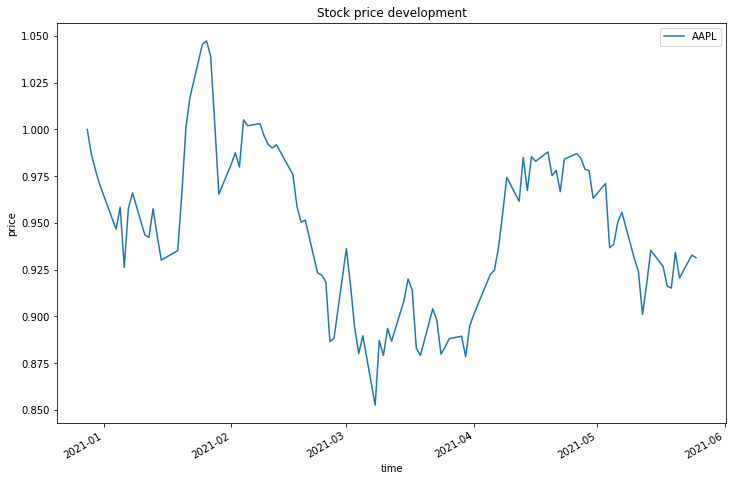

In [879]:
plot_stock_data(data_analysis_norm)

### 3. Feature engineering

In [880]:
# Simple moving average (SMA)

win = 10
sma = data_analysis_norm.rolling(window=win).mean()
std_df = data_analysis_norm.rolling(window=win).std()
sma.tail()
std_df.tail()

,AAPL
2021-05-19,0.016654
2021-05-20,0.014823
2021-05-21,0.010452
2021-05-24,0.010638
2021-05-25,0.011011


In [881]:
# Bollinger(R) Bands

def get_bollinger_bands(rm=sma, rstd=std_df):
    upper_band = rm + rstd*2
    lower_band = rm - rstd*2
    return upper_band, lower_band


In [882]:
b_upper_band, b_lower_band = get_bollinger_bands()
b_upper_band.tail()

,AAPL
2021-05-19,0.960605
2021-05-20,0.955321
2021-05-21,0.943071
2021-05-24,0.943627
2021-05-25,0.945099


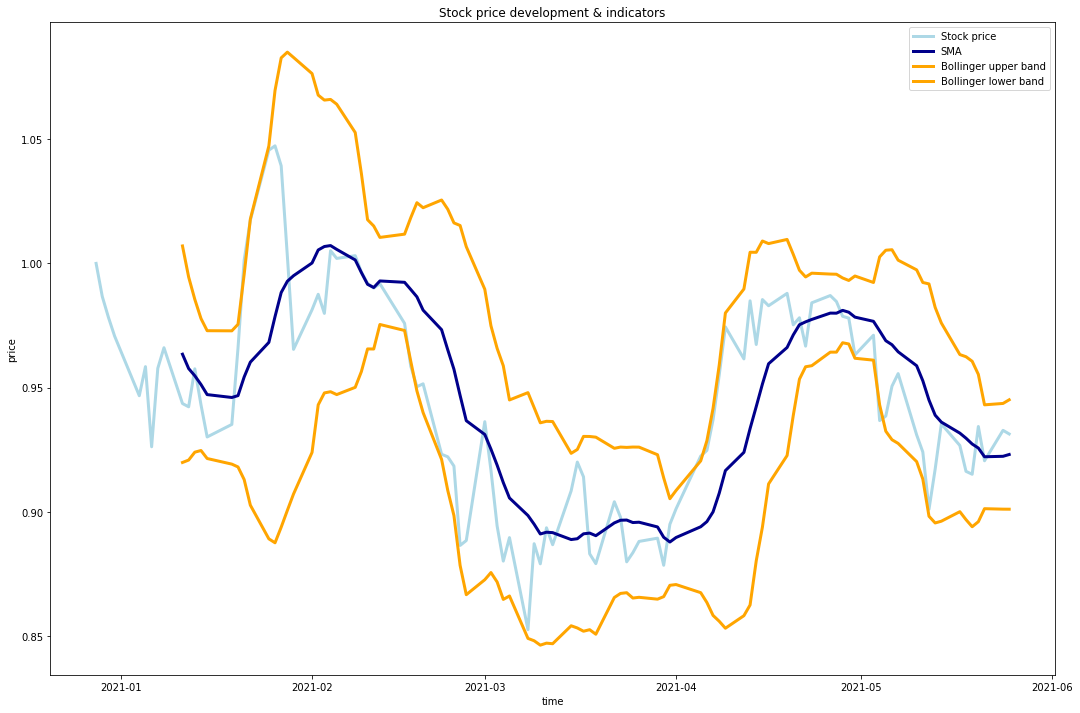

In [883]:
plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
ax.set_xlabel('time')
ax.set_ylabel('price')
ax.set_title('Stock price development & indicators')
ax.plot(data_analysis_norm, color='lightblue', linewidth=3, label='Stock price')
ax.plot(sma, color='darkblue', linewidth=3, label='SMA')
ax.plot(b_upper_band, color='orange', linewidth=3, label='Bollinger upper band')
ax.plot(b_lower_band, color='orange', linewidth=3, label='Bollinger lower band')
plt.legend(loc='upper right');

In [884]:
# Daily returns

def get_daily_returns(df=data_analysis_df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

In [885]:
daily_returns = get_daily_returns()
daily_returns.head()

,AAPL
2020-12-28,0.000000
2020-12-29,-0.013315
2020-12-30,-0.008527
2020-12-31,-0.007703
2021-01-04,-0.024719


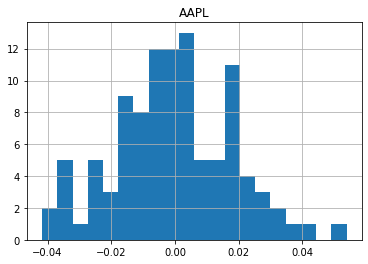

In [886]:
daily_returns.hist(bins= 20)
plt.show()

In [887]:
# Cumulative returns

def get_cumulative_returns(df=data_analysis_df):
    cumulative_returns = df.copy
    cumulative_returns= (df/df.iloc[0]) - 1
    return cumulative_returns

In [888]:
cumulative_returns = get_cumulative_returns()
cumulative_returns.head()

,AAPL
2020-12-28,0.000000
2020-12-29,-0.013315
2020-12-30,-0.021728
2020-12-31,-0.029263
2021-01-04,-0.053259


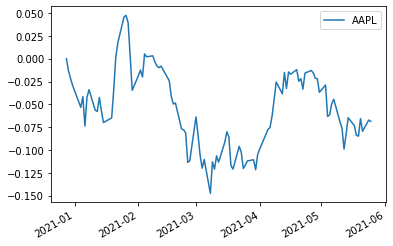

In [889]:
cumulative_returns.plot();

In [890]:
# Momentum

def get_momentum(df=data_analysis_df, win=5):
    df_momentum = df.copy()
    df_momentum[win:] = (df[win:]/df[:-(win)].values) - 1
    df_momentum.iloc[0:(win),:] = 0
    return df_momentum

In [891]:
momentum = get_momentum()
momentum.tail()

,AAPL
2021-05-19,0.015639
2021-05-20,0.018724
2021-05-21,-0.015849
2021-05-24,0.006573
2021-05-25,0.016420


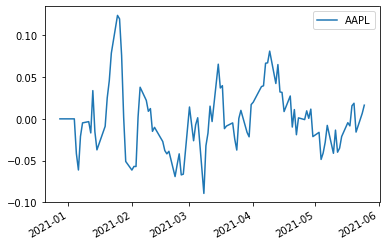

In [892]:
momentum.plot();

In [894]:
# Get market index

market_index = get_data(symbol='SPY', start_date='2020-12-25', end_date='2021-05-25')
market_index.head(), market_index.tail()


(                   SPY
 2020-12-28  370.952995
 2020-12-29  370.245316
 2020-12-30  370.773583
 2020-12-31  372.657403
 2021-01-04  367.584047,
                SPY
 2021-05-19  410.86
 2021-05-20  415.28
 2021-05-21  414.94
 2021-05-24  419.17
 2021-05-25  418.24)

In [895]:
market_index_norm = normalize_stock_data(market_index)

### 4. Merge all indicators and symbols into one dataframe

In [896]:
def create_indicator_dataframe(df):
    ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
        and joins all indicators to one dataframe 
        INPUT: 
        df - dataframe - contains the orginal data to analyse 
        OUTPUT:
        indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
    indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
    
    for symbol in df.columns:
        df_temp = df[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
        df_temp['Symbol']= symbol

        df_temp = df_temp.join(daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
        df_temp = df_temp.join(cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
        df_temp = df_temp.join(sma[symbol], on='Date').rename(columns={symbol:'SMA'})
        df_temp = df_temp.join(momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
        df_temp = df_temp.join(b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
        df_temp = df_temp.join(b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
        df_temp = df_temp.join(market_index['SPY'], on='Date').rename(columns={'SPY':'Market Index'})
        indicator_df = pd.concat([indicator_df, df_temp])
        
        indicator_df.fillna(method='ffill', inplace=True)
        indicator_df.fillna(method='bfill', inplace=True)
        indicator_df.dropna()
    
    return indicator_df

In [897]:
indicator_model_df = create_indicator_dataframe(data_analysis_df)
indicator_model_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2020-12-28,AAPL,136.255198,0.000000,0.000000,0.963450,0.000000,1.007037,0.919863,370.952995
1,2020-12-29,AAPL,134.440987,-0.013315,-0.013315,0.963450,0.000000,1.007037,0.919863,370.245316
2,2020-12-30,AAPL,133.294645,-0.008527,-0.021728,0.963450,0.000000,1.007037,0.919863,370.773583
3,2020-12-31,AAPL,132.267922,-0.007703,-0.029263,0.963450,0.000000,1.007037,0.919863,372.657403
4,2021-01-04,AAPL,128.998355,-0.024719,-0.053259,0.963450,0.000000,1.007037,0.919863,367.584047
...,...,...,...,...,...,...,...,...,...,...
98,2021-05-19,AAPL,124.690000,-0.001282,-0.084879,0.927298,0.015639,0.960605,0.893990,410.860000
99,2021-05-20,AAPL,127.310000,0.021012,-0.065650,0.925675,0.018724,0.955321,0.896028,415.280000
100,2021-05-21,AAPL,125.430000,-0.014767,-0.079448,0.922167,-0.015849,0.943071,0.901262,414.940000
101,2021-05-24,AAPL,127.100000,0.013314,-0.067192,0.922350,0.006573,0.943627,0.901073,419.170000


## II. MACHINE LEARNING PIPELINE 

### 1. Create train and test data and standardize

In [967]:
from sklearn import preprocessing

def create_train_test_data(indicator_df, symbol, start_pred, end_pred, train_size=0.8):
    ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
        INPUT:
        indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
        symbol - str - symbol of the listed company for which you want to predict stock price
        train_size - float - size of train dataset
        start_pred - str - start date of prediction
        end_pred - str - end date of prediction
        OUTPUT:
        pred_days - int - days to be predicted
        Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        X_train - nd array - contains the training dataset of the independent variables
        X_test - nd array - contains the test dataset of the independent variables
        X_predict = nd array - contains the data of the independent variable for the prediction period
        time_series_train - 1d array - selected time period of training data
        time_series_test - 1d array - selected time period of test data
    '''
    sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
    ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')
    
    try:
        if sd >= ed:
            raise ValueError('Start date beyound end date')
        else:
            pred_days = (ed-sd).days

            indicator_df = indicator_df[indicator_df['Date'] <= start_pred] 
            
            df = indicator_df.copy().drop(['Symbol','Date'], axis=1)
            
            for i in range(1,pred_days):
                indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))

        
            train_df = indicator_df.copy().iloc[pred_days:] # Training data starts from the date where data for all indicators is available
            
            if pred_days > 0:
                X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                X_predict = train_df.iloc[-pred_days:, 3:]
                Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe
                
                X.fillna(method='ffill', inplace=True)
                X.fillna(method='bfill', inplace=True)

                Y.fillna(method='ffill', inplace=True)
                Y.fillna(method='bfill', inplace=True)
                
            
            train_ct = int(X.shape[0] * train_size)
            test_ct = X.shape[0] - train_size

            X_train, X_test = X.iloc[:train_ct], X.iloc[train_ct:]  
            Y_train, Y_test = Y.iloc[:train_ct].copy().drop('Date', axis=1), Y.iloc[train_ct:].copy().drop('Date', axis=1)

            time_series_train = Y.iloc[:train_ct].Date
            time_series_test = Y.iloc[train_ct:].Date   


            return pred_days, preprocessing.scale(X_train), Y_train['Adj Close'].tolist(), preprocessing.scale(X_test), Y_test['Adj Close'].tolist(), time_series_train, time_series_test, preprocessing.scale(X_predict)
        
    
    except ValueError:
        raise
        

In [992]:
pred_days, X_train, Y_train, X_test, Y_test, time_series_train, time_series_test, X_predict   = create_train_test_data(indicator_model_df, symbol='AAPL', start_pred='2021-05-15', end_pred='2021-05-20', train_size=0.8)

In [993]:
pred_days, len(X_train), len(Y_train),  len(time_series_train)

(5, 68, 68, 68)

In [994]:
len(X_test), len(Y_test),len(time_series_test)

(18, 18, 18)

### 2. Setup and validate different models

In [995]:
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [996]:
# Evaluate model performance and plot data
def evaluate_model_performance(Y_test, Y_predict, Y_future, time_series_test):
    ''' Function that generates different performance indicators comparing test data and the predicted data
        and plots the data
        INPUT:
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        Y_predict - 1d array - contains the predicted dataset of the dependent variable (stock price) for the test period
        Y_future - 1d array - contains the predicted dataset of the dependent variable (stock price) for a future period
        time_series_test - 1d array - selected time period of test data
    '''
    
    corr = np.corrcoef(Y_test, Y_predict)
    corrcoef = corr[0,1]
    mae = mean_absolute_error(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    
    fig = plt.figure(figsize=(12,8))
    
    value_days = len(Y_future)
    end_date = (time_series_test.iloc[-1] + dt.timedelta(days=value_days))

    time_series_future = pd.date_range(time_series_test.iloc[-1] + dt.timedelta(days=1) , end_date).tolist()
    

    plt.plot(time_series_test, Y_test, color='lightblue', linewidth=2, label='test data')
    plt.plot(time_series_test, Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')
    
    plt.plot(time_series_future , Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')
    
    plt.legend()
    
    return print(('MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(mae, mape, r2 , corrcoef))

In [997]:
# Lasso LARS

lassolars = linear_model.LassoLars(alpha = 0.1)
lassolars.fit(X_train, Y_train)
Y_lassolars_predict = lassolars.predict(X_test)
Y_lassolars_future = lassolars.predict(X_predict)

MAE 2.342397719541426 
 MAPE 0.01794216385715601 
 r2 0.37334522906248424 
 CORRCOEF 0.7914236081144906 



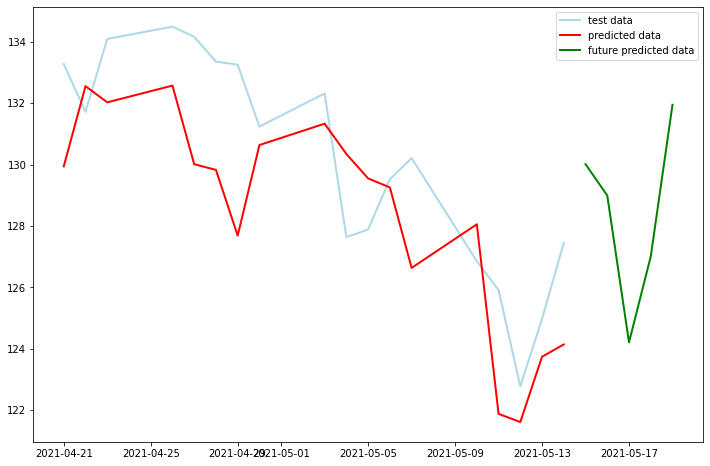

In [998]:
evaluate_model_performance(Y_test, Y_lassolars_predict, Y_lassolars_future, time_series_test)

In [999]:
Y_lassolars_future

array([130.01303755, 128.99012632, 124.20411223, 127.00275109,
       131.9486494 ])

In [1000]:
# knn
knn = KNeighborsRegressor(n_neighbors=15)  #weights='distance'
knn.fit(X_train, Y_train)
Y_knn_predict = knn.predict(X_test)
Y_knn_future = knn.predict(X_predict)

MAE 2.9003871107925994 
 MAPE 0.022178743829784263 
 r2 -0.2708068569315625 
 CORRCOEF 0.4157665285885926 



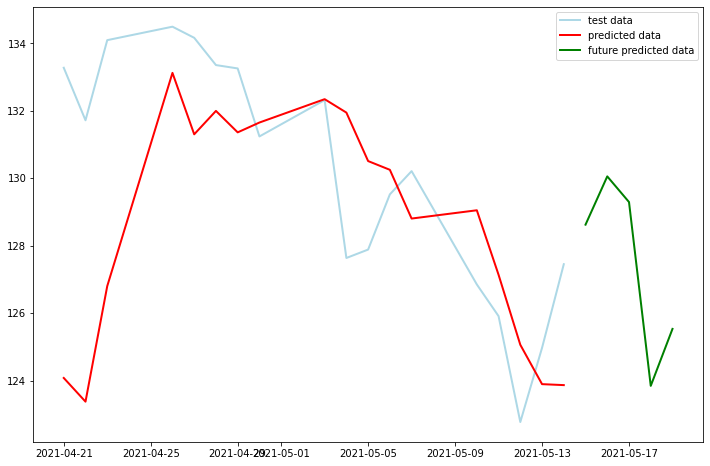

In [1001]:
evaluate_model_performance(Y_test, Y_knn_predict, Y_knn_future, time_series_test)

In [1002]:
# AdaBoost
AdaBoost = AdaBoostRegressor(base_estimator=knn, random_state=42)
AdaBoost.fit(X_train, Y_train)
Y_AdaBoost_predict = AdaBoost.predict(X_test)
Y_AdaBoost_future = AdaBoost.predict(X_predict)

MAE 3.3421564260037067 
 MAPE 0.025661134726348386 
 r2 -0.4595010066485703 
 CORRCOEF 0.31638970494451985 



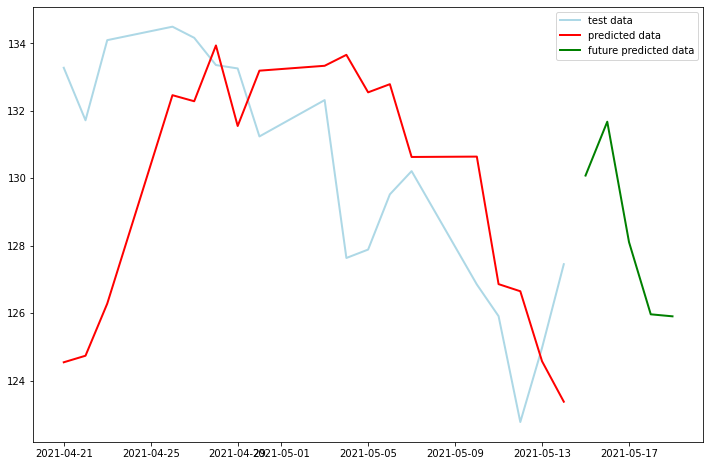

In [1003]:
evaluate_model_performance(Y_test, Y_AdaBoost_predict, Y_AdaBoost_future, time_series_test)

In [1004]:
# Random Forest Regression
randomforest = RandomForestRegressor(random_state=42, criterion='mse', n_estimators=10, min_samples_split=10)
randomforest.fit(X_train, Y_train)
Y_randomforest_predict = randomforest.predict(X_test)
Y_randomforest_future = randomforest.predict(X_predict)

MAE 3.0285611715061185 
 MAPE 0.023346266266300895 
 r2 -0.0011986899151184005 
 CORRCOEF 0.5908766010043889 



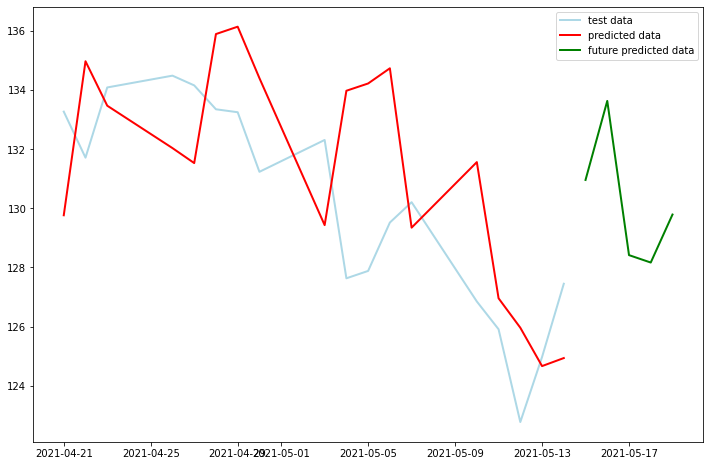

In [1005]:
evaluate_model_performance(Y_test, Y_randomforest_predict, Y_randomforest_future, time_series_test)

### 3. Put all the above into one class

In [1006]:
class StockDataAnalysis():
    ''' Creates a StockDataAnalysis object which is able to take one or mutiple stock symbols and a timeframe and then computes
        a range of indicators on the stock data and plots the results'''
    
    def __init__(self, symbol='AAPL', start_date='2020-01-01', end_date='2021-04-16'):
        ''' Create an instance of StockDataAnalysis'''
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = get_data(self.symbol, self.start_date, self.end_date)
        self.data_norm = normalize_stock_data(self.data)
        
    # Plot stock price data and check for anomalies

    def plot_stock_data(self, normalized=True):
        if normalized:
            df = self.data_norm
            title_str = 'Relative stock price development'
        else:
            df = self.data
            title_str = 'Absolute stock price development'
        if isinstance(df, pd.Series):
            plt.figure(figsize=(12,8))
            ax1 = df.plot()
            ax1.set_xlabel('time')
            ax1.set_ylabel('price')
            ax1.set_title(title_str)
            plt.legend(loc='upper right')
            plt.show()
        else:
            plt.figure(figsize=(12,18))
            ax2 = plt.subplot(2,1,1)
            ax2.set_xlabel('time')
            ax2.set_ylabel('price development')
            ax2.set_title(title_str)
            for col in df.columns:
                df[col].plot()
        
            plt.legend(loc='upper right')
           
    def calculate_rolling_stats(self, win=10):
        rm = self.data_norm.rolling(window=win).mean()
        rstd = self.data_norm.rolling(window=win).std()
        self.sma = rm.dropna()
        self.rstd = rstd.dropna()
        
    def calculate_bollinger_bands(self):
        self.b_upper_band = self.sma + self.rstd*2
        self.b_lower_band = self.sma - self.rstd*2
            
    def calculate_daily_returns(self):
        daily_returns = self.data.copy()
        daily_returns[1:] = (self.data[1:]/self.data[:-1].values) - 1
        daily_returns.iloc[0,:] = 0
        self.daily_returns = daily_returns
        

    def calculate_cumulative_returns(self):
        cumulative_returns = self.data.copy
        cumulative_returns= (self.data/self.data.iloc[0]) - 1
        self.cumulative_returns = cumulative_returns
        
        
    def calculate_momentum(self, win=5):
        self.momentum = self.data.copy()
        self.momentum[win:] = (self.data[win:]/self.data[:-(win)].values) - 1
        self.momentum.iloc[0:(win),:] = 0
        
    
    def get_market_index(self, market_ix='SPY'):
        self.market_ix = market_ix
        self.market_index = get_data(symbol=market_ix, start_date=self.start_date, end_date=self.end_date)
        
    def setup_features(self, market_ix='SPY'):
        self.calculate_rolling_stats()
        self.calculate_bollinger_bands()
        self.calculate_daily_returns()
        self.calculate_cumulative_returns()
        self.calculate_momentum()
        self.get_market_index(market_ix=market_ix)
        
            
    def create_indicator_dataframe(self):
        ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
            and joins all indicators to one dataframe 
            INPUT: 
            object 
            OUTPUT:
            indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
        
        self.indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
        
        for symbol in self.data.columns:
            df_temp = self.data[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
            df_temp['Symbol'] = symbol
            
            df_temp = df_temp.join(self.daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
            df_temp = df_temp.join(self.cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
            df_temp = df_temp.join(self.sma[symbol], on='Date').rename(columns={symbol:'SMA'})
            df_temp = df_temp.join(self.momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
            df_temp = df_temp.join(self.b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
            df_temp = df_temp.join(self.b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
            df_temp = df_temp.join(self.market_index[self.market_ix], on='Date').rename(columns={self.market_ix:'Market Index'})                   

            self.indicator_df = pd.concat([self.indicator_df, df_temp])
            
            self.indicator_df.fillna(method='ffill', inplace=True)
            self.indicator_df.fillna(method='bfill', inplace=True)
            self.indicator_df.dropna()

        return self.indicator_df

In [1007]:
st_data = StockDataAnalysis('AAPL','2020-12-25','2021-05-25')

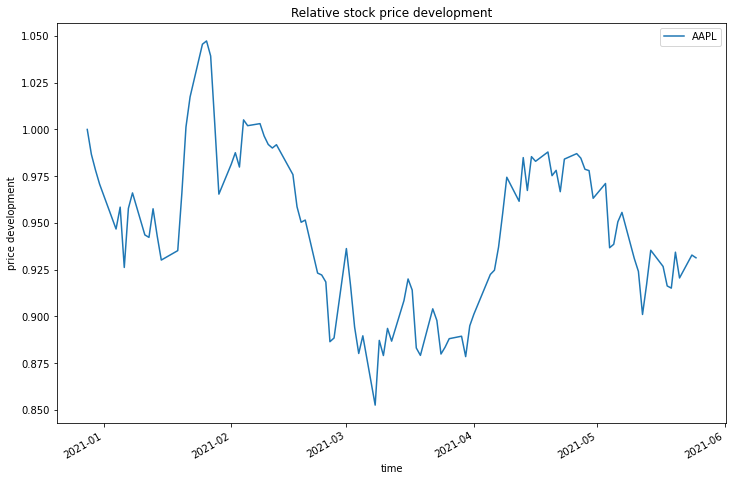

In [1008]:
st_data.plot_stock_data()

In [1009]:
st_data.setup_features()

In [1010]:
st_data.calculate_rolling_stats()

In [1011]:
st_data.calculate_bollinger_bands()

In [1012]:
st_data.calculate_daily_returns()

In [1013]:
st_data.calculate_momentum()

In [1014]:
st_data.calculate_cumulative_returns()

In [1015]:
st_data.get_market_index()

In [1016]:
st_data.create_indicator_dataframe()
st_data.indicator_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2020-12-28,AAPL,136.255198,0.000000,0.000000,0.963450,0.000000,1.007037,0.919863,370.952995
1,2020-12-29,AAPL,134.440987,-0.013315,-0.013315,0.963450,0.000000,1.007037,0.919863,370.245316
2,2020-12-30,AAPL,133.294645,-0.008527,-0.021728,0.963450,0.000000,1.007037,0.919863,370.773583
3,2020-12-31,AAPL,132.267922,-0.007703,-0.029263,0.963450,0.000000,1.007037,0.919863,372.657403
4,2021-01-04,AAPL,128.998355,-0.024719,-0.053259,0.963450,0.000000,1.007037,0.919863,367.584047
...,...,...,...,...,...,...,...,...,...,...
98,2021-05-19,AAPL,124.690000,-0.001282,-0.084879,0.927298,0.015639,0.960605,0.893990,410.860000
99,2021-05-20,AAPL,127.310000,0.021012,-0.065650,0.925675,0.018724,0.955321,0.896028,415.280000
100,2021-05-21,AAPL,125.430000,-0.014767,-0.079448,0.922167,-0.015849,0.943071,0.901262,414.940000
101,2021-05-24,AAPL,127.100000,0.013314,-0.067192,0.922350,0.006573,0.943627,0.901073,419.170000


In [1045]:
class ModelStockPrice():
    def __init__(self, start_predict=None, end_predict=None):
        '''Create an instance of the model to predict stockprice'''
        
        self.start_predict = start_predict
        self.end_predict = end_predict
        
        self.model = RandomForestRegressor(random_state=42, criterion='mse', n_estimators=10, min_samples_split=10)


    def create_train_test_data(self, stockdata, train_size=0.8, start_pred='2019-05-10', end_pred='2019-05-17'):
        ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
            INPUT:
            indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
            symbol - str - symbol of the listed company for which you want to predict stock price
            train_size - float - size of train dataset
            start_pred - str - start date of prediction
            end_pred - str - end date of prediction
            OUTPUT:
            pred_days - int - days to be predicted
            Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            X_train - nd array - contains the training dataset of the independent variables
            X_test - nd array - contains the test dataset of the independent variables
            X_predict = nd array - contains the data of the independent variable for the prediction period
            time_series_train - 1d array - selected time period of training data
            time_series_test - 1d array - selected time period of test data
            time_series_test - 1d array - predicted time period

        '''
        sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
        ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')

        try:
            if sd >= ed:
                raise ValueError('Start date beyound end date')
            else:
                self.pred_days = (ed-sd).days

                indicator_df = stockdata.indicator_df[stockdata.indicator_df['Date'] <= start_pred] 

                df = stockdata.indicator_df.copy().drop(['Symbol','Date'], axis=1)

                for i in range(1, self.pred_days):
                    indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))


                train_df = indicator_df.copy().iloc[self.pred_days:] # Training data starts from the date where data for all indicators is available

                if self.pred_days > 0:
                    X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                    self.X_predict = preprocessing.scale(train_df.iloc[-pred_days:, 3:])
                    Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe

                    X.fillna(method='ffill', inplace=True)
                    X.fillna(method='bfill', inplace=True)

                    Y.fillna(method='ffill', inplace=True)
                    Y.fillna(method='bfill', inplace=True)


                train_ct = int(X.shape[0] * train_size)
                test_ct = X.shape[0] - train_size

                self.X_train, self.X_test = preprocessing.scale(X.iloc[:train_ct]), preprocessing.scale(X.iloc[train_ct:])  
                self.Y_train, self.Y_test = Y.iloc[:train_ct, 1].copy().tolist(), Y.iloc[train_ct:, 1].copy().tolist()

                self.time_series_train = Y.iloc[:train_ct].Date
                self.time_series_test = Y.iloc[train_ct:].Date   
                

                return self.pred_days, self.X_train, self.Y_train, self.X_test, self.Y_test, self.time_series_train, self.time_series_test, X_predict
            
        except ValueError:
            raise

            
    def fit(self):
        '''Fit the model with training data '''
        self.model.fit(self.X_train, self.Y_train)

    def predict(self):
        '''Predict stockprice '''
        self.Y_predict = self.model.predict(self.X_test)
        self.Y_future = self.model.predict(self.X_predict)
        return self.Y_predict, self.Y_future
    
    def evaluate_model_performance(self):
        ''' Function that generates different performance indicators comparing test data and the predicted data
            and plots the data
            INPUT:
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            Y_predict - 1d array - contains the predicted dataset of the dependent variable (stock price) for the test period
            Y_future - 1d array - contains the predicted dataset of the dependent variable (stock price) for a future period
            time_series_test - 1d array - selected time period of test data
        '''

        corr = np.corrcoef(self.Y_test, self.Y_predict)
        corrcoef = corr[0,1]
        mae = mean_absolute_error(self.Y_test, self.Y_predict)
        mape = mean_absolute_percentage_error(self.Y_test, self.Y_predict)
        r2 = r2_score(self.Y_test, self.Y_predict)

        fig = plt.figure(figsize=(12,8))

        value_days = len(self.Y_future)
        end_date = (self.time_series_test.iloc[-1] + dt.timedelta(days=value_days))

        time_series_future = pd.date_range(self.time_series_test.iloc[-1]+ dt.timedelta(days=1) , end_date).tolist()

        plt.plot(self.time_series_test, self.Y_test, color='lightblue', linewidth=2, label='test data')
        plt.plot(self.time_series_test, self.Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')

        plt.plot(time_series_future , self.Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')

        plt.legend()

        return print(('MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(mae, mape, r2 , corrcoef))
    

In [1046]:
price_reg = ModelStockPrice()

In [1047]:
price_reg.create_train_test_data(st_data, start_pred='2021-05-15', end_pred='2021-05-20')

(5,
 array([[ 0.5709274 ,  0.38310988,  0.53858899, ...,  0.36781387,
          0.54669512, -1.66371733],
        [-1.69891044, -0.30263781,  0.53858899, ...,  0.36781387,
          0.54669512, -1.60486168],
        [ 1.6440391 ,  0.36911503,  0.53858899, ...,  0.36781387,
          0.54669512, -1.39498023],
        ...,
        [ 0.95803965,  0.72277367, -0.60182575, ..., -1.32636538,
         -0.85715032,  2.35991745],
        [-0.68960769,  0.44946501, -0.42297253, ..., -1.16803104,
         -0.96307179,  2.3331784 ],
        [ 1.15991227,  0.94624827, -0.19044551, ..., -0.91210424,
         -1.10280433,  2.38554237]]),
 [128.390295356,
  130.473647199,
  128.49994545299998,
  126.73557571100001,
  127.423380865,
  131.610020931,
  136.434625197,
  138.62762713700002,
  142.465380531,
  142.704617106,
  141.608116136,
  136.653925391,
  131.540243597,
  133.713309155,
  134.560605358,
  133.513945342,
  136.95297111,
  136.529323009,
  136.679069999,
  135.780588055,
  135.161633827

In [1048]:
price_reg.fit()

In [1049]:
Y_predict, Y_future_predict = price_reg.predict()
Y_future_predict

array([130.96332036, 133.63803463, 128.41882388, 128.16798734,
       129.79235665])

MAE 3.0285611715061185 
 MAPE 0.023346266266300895 
 r2 -0.0011986899151184005 
 CORRCOEF 0.5908766010043889 



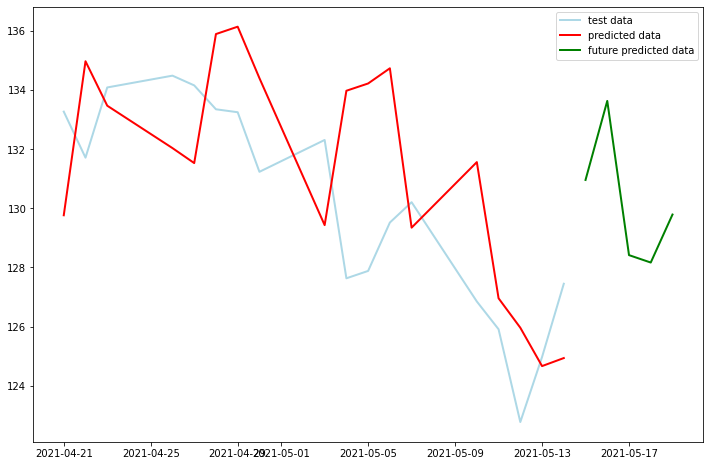

In [1050]:
price_reg.evaluate_model_performance()